## Import libs and data

In [2]:
import dask.dataframe as dd
import os
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay,roc_curve, auc, make_scorer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler
import pickle

# Paths

In [3]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_svm_pq = os.path.join(processed_dir, 'minority_users_svm.parquet')

models_dir = os.path.join( "..", "models","models")
model_dump_path = os.path.join(models_dir, 'svm_model.pkl')

Import Dataset

In [4]:
# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,False
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,False
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,False
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,False
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,False
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,False
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,False
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,False


In [5]:
y = fds["malicious"].compute()
X = fds.drop(columns=["malicious",]).compute()
# X = fds.drop(columns=["targetLabel","user"]).compute()

## Preprocessing and Split

In [6]:
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])
print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({False: 1574, True: 26})


In [7]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SVM

In [8]:
def make_binary_labels(labels):
    return np.where(labels == 1, -1, 1)

y_train_gs = make_binary_labels(y_train)
y_test_gs = make_binary_labels(y_test)


In [9]:
# Create a scorer using make_scorer
def custom_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=1)

scorer = make_scorer(custom_f1_score, greater_is_better=True)

# defining parameter range 
param_grid = {
    'nu': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001, 1.0, 10.0]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

grid = GridSearchCV(OneClassSVM(), param_grid, refit = True, verbose = 3, scoring=scorer) 

# fitting the model for grid search 
grid.fit(X_train_scaled, y_train_gs) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 1/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.630 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.819 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.737 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.844 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.001;, score=0.848 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.320 total time=   0.0s
[CV 2/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.919 total time=   0.0s
[CV 3/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.754 total time=   0.0s
[CV 4/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.751 total time=   0.0s
[CV 5/5] END gamma=scale, kernel=linear, nu=0.005;, score=0.808 total time=   0.0s
[CV 1/5] END gamma=scale, kernel=linear, nu=0.01;, score=0.685 total time=   0.0s
[CV 2/5] END gamma=scale

In [10]:
best_clf = grid

In [11]:
# (-1 for outliers, 1 for inliers)
print("##############################")
print("Test Evaluation")
print("##############################")

test_pred = best_clf.predict(X_test_scaled) 

print(classification_report(y_true=y_test_gs, y_pred=test_pred,labels=labels, target_names=['Normal', 'Malicious'])) 

conf_matrix = confusion_matrix(y_test_gs, test_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Malicious'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

##############################
Test Evaluation
##############################


NameError: name 'labels' is not defined

In [ ]:
def plot_roc(clf, y_test, y_pred):

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for One-Class SVM')
    plt.legend(loc="lower right")
    plt.show()

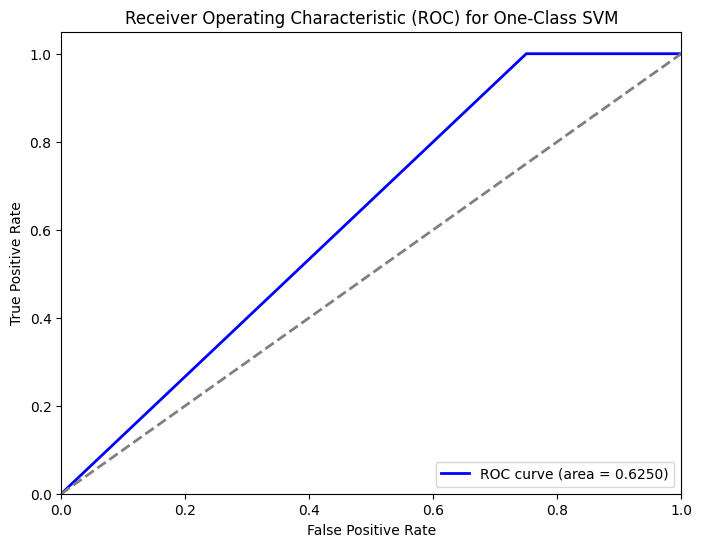

In [ ]:
# ROC for best SVM, grid search
plot_roc(best_clf, y_test_gs, test_pred)

## Confidence scores

In [ ]:
class ConfidenceScore:
    def __init__(self, clf, X):
        self.clf = clf
        distances = clf.decision_function(X)
        self.min = min(distances)
        self.max = max(distances)
        
    def get_confi_score(self, X):
        def min_max_scaling(value, new_min, new_max):
            old_min = min(min(value), self.min) 
            old_max = max(max(value), self.max)
            if old_max == old_min:
                return np.zeros_like(value) if old_max == 0 else np.ones_like(value) * ((new_max - new_min) / 2) + new_min
            else:
                scaled_value = ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
                return scaled_value
        
        # Distance from decision boundary where positive = non-anomaly and negative = anomaly
        distances = self.clf.decision_function(X)
        
        # Scale negative distances on the negative scale and positive distances on the positive scale
        neg_distances = distances[distances < 0]
        pos_distances = distances[distances >= 0]
        
        scaled_neg = min_max_scaling(neg_distances, -1, 0)
        scaled_pos = min_max_scaling(pos_distances, 0, 1)
        
        # Combine scaled distances
        risk_scores = np.empty_like(distances)
        risk_scores[distances < 0] = scaled_neg
        risk_scores[distances >= 0] = scaled_pos
        confidence = np.abs(risk_scores)
        return confidence


In [ ]:
confidence_scorer = ConfidenceScore(best_clf, X_train_scaled)
train_confi = confidence_scorer.get_confi_score(X_train_scaled)
test_confi = confidence_scorer.get_confi_score(X_test_scaled)

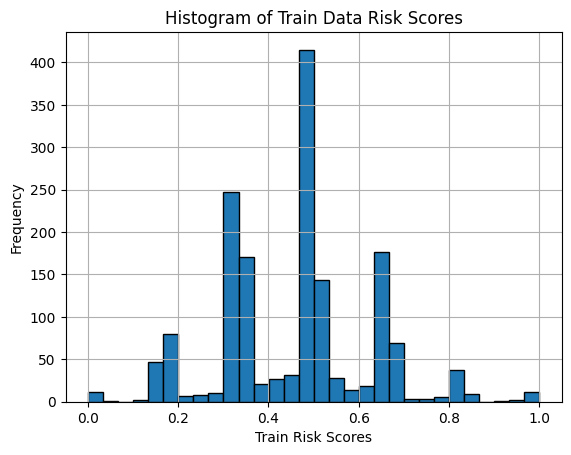

In [ ]:
# Plot histogram
plt.hist(train_confi, bins=30, edgecolor='black') 
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Data Risk Scores')
plt.grid(True)
plt.show()

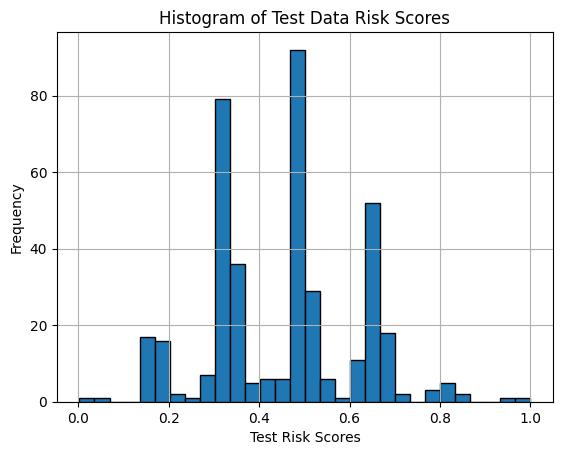

In [ ]:

# Plot histogram
plt.hist(test_confi, bins=30, edgecolor='black')
plt.xlabel('Test Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

# Export Model

In [ ]:
pickle.dump(best_clf, open(model_dump_path,'wb'))

#  Our Prediction and the Confidence Associated with it

## Helper Functions

In [ ]:
def df_toparquet(pdf,path):
    ddf = dd.from_pandas(pdf)
    # Export the DataFrame to a parquet file=
    ddf.to_parquet(path, engine='pyarrow')


In [ ]:
def get_minority_tables(y_pred_value, y_test_value,df):
    # Get rows of minority data
    minority_data = df[(df['Actual'] == y_test_value) & (df['Prediction'] == y_pred_value)]
    display(minority_data)

In [ ]:
names_array = list(X_test_w_name['user'].iloc)
test_pred_ = np.where(test_pred == 1, 0, 1)
final_guess = {'User': names_array, 'Actual': y_test, 'Prediction': test_pred_.astype(bool), 'Confidence of Prediction': test_confi}
final_guess = pd.DataFrame(final_guess)
df_toparquet(final_guess,minority_users_svm_pq)
final_guess


,User,Actual,Prediction,Confidence of Prediction
1860,VAH1292,False,False,0.828321
353,CJL0143,False,False,0.153613
1333,MMB1967,False,False,0.339162
905,IVS1411,False,False,0.508965
1289,MEB1743,False,False,0.490138
...,...,...,...,...
965,JIG1593,False,False,0.168591
1284,MDL0294,False,False,0.376346
1739,SSG0726,False,False,0.329606
261,BWJ1539,False,False,0.474783


In [ ]:
print("False Positives")
get_minority_tables(1, 0,final_guess)

print("False Negatives")
get_minority_tables(0, 1,final_guess)

print("True Positives")
get_minority_tables(1,1,final_guess)

False Positives


,User,Actual,Prediction,Confidence of Prediction


False Negatives


,User,Actual,Prediction,Confidence of Prediction
1473,OKM1092,True,False,0.492596
1813,TNB1616,True,False,0.647507
1274,MCP0611,True,False,0.524819


True Positives


,User,Actual,Prediction,Confidence of Prediction
1810,TMT0851,True,True,1.0
